In [1]:
from PIL import Image
from numpy import array, zeros, uint8
import subprocess
from io import BytesIO
from os.path import basename, splitext, join
import os
from shutil import rmtree

from plot_layers import plot_layers

In [3]:
def img_diff(i1, i2, doInvert=True):
    ''' doInvert: set true whe input is black on white background '''
    a0 = array(i1)
    a1 = array(i2)
    if doInvert:
        a0 = ~a0
        a1 = ~a1
    a_out = zeros((a0.shape[0], a0.shape[1], 3), dtype=uint8)

    # Black background (looks nicer!)
    common = a0 & a1
    diff1 = a1 & ~common
    diff2 = a0 & ~common

    a_out[:, :, 0] = common * 0.2 + diff1 * 0.8
    a_out[:, :, 1] = common * 0.2 + diff2 * 0.8
    a_out[:, :, 2] = common * 0.2

    # White background (simpler!)
    # a_out[:, :, 0] = a0
    # a_out[:, :, 1] = a1
    # a_out[:, :, 2] = a0 & a1

    return Image.fromarray(a_out)

In [51]:
def load_svg(fName):
    png_str = subprocess.check_output(['rsvg-convert', '-b', 'white', fName])   
    return Image.open(BytesIO(png_str)).convert('L')

def load_pdf(fName, x=4.7, y=2.6, W=7.3, H=6.0, r=600):
    ''' 
    x, y, W, H: crop window [inch]
    r: resolution [dpi]
    '''
    ppm_str = subprocess.check_output([
        'pdftoppm',
        '-r', str(int(r)),
        '-x', str(int(x * r)),
        '-y', str(int(y * r)),
        '-W', str(int(W * r)),
        '-H', str(int(H * r)),
        fName
    ])
    return Image.open(BytesIO(ppm_str)).convert('L')

def desc():
    return subprocess.check_output(['git', 'describe']).strip()

In [61]:
i1 = load_pdf('out1/AMC_FMC_Carrier-PcbDoc-B_Cu.pdf', r=400)
i2 = load_pdf('out2/AMC_FMC_Carrier-PcbDoc-B_Cu.pdf', r=400)

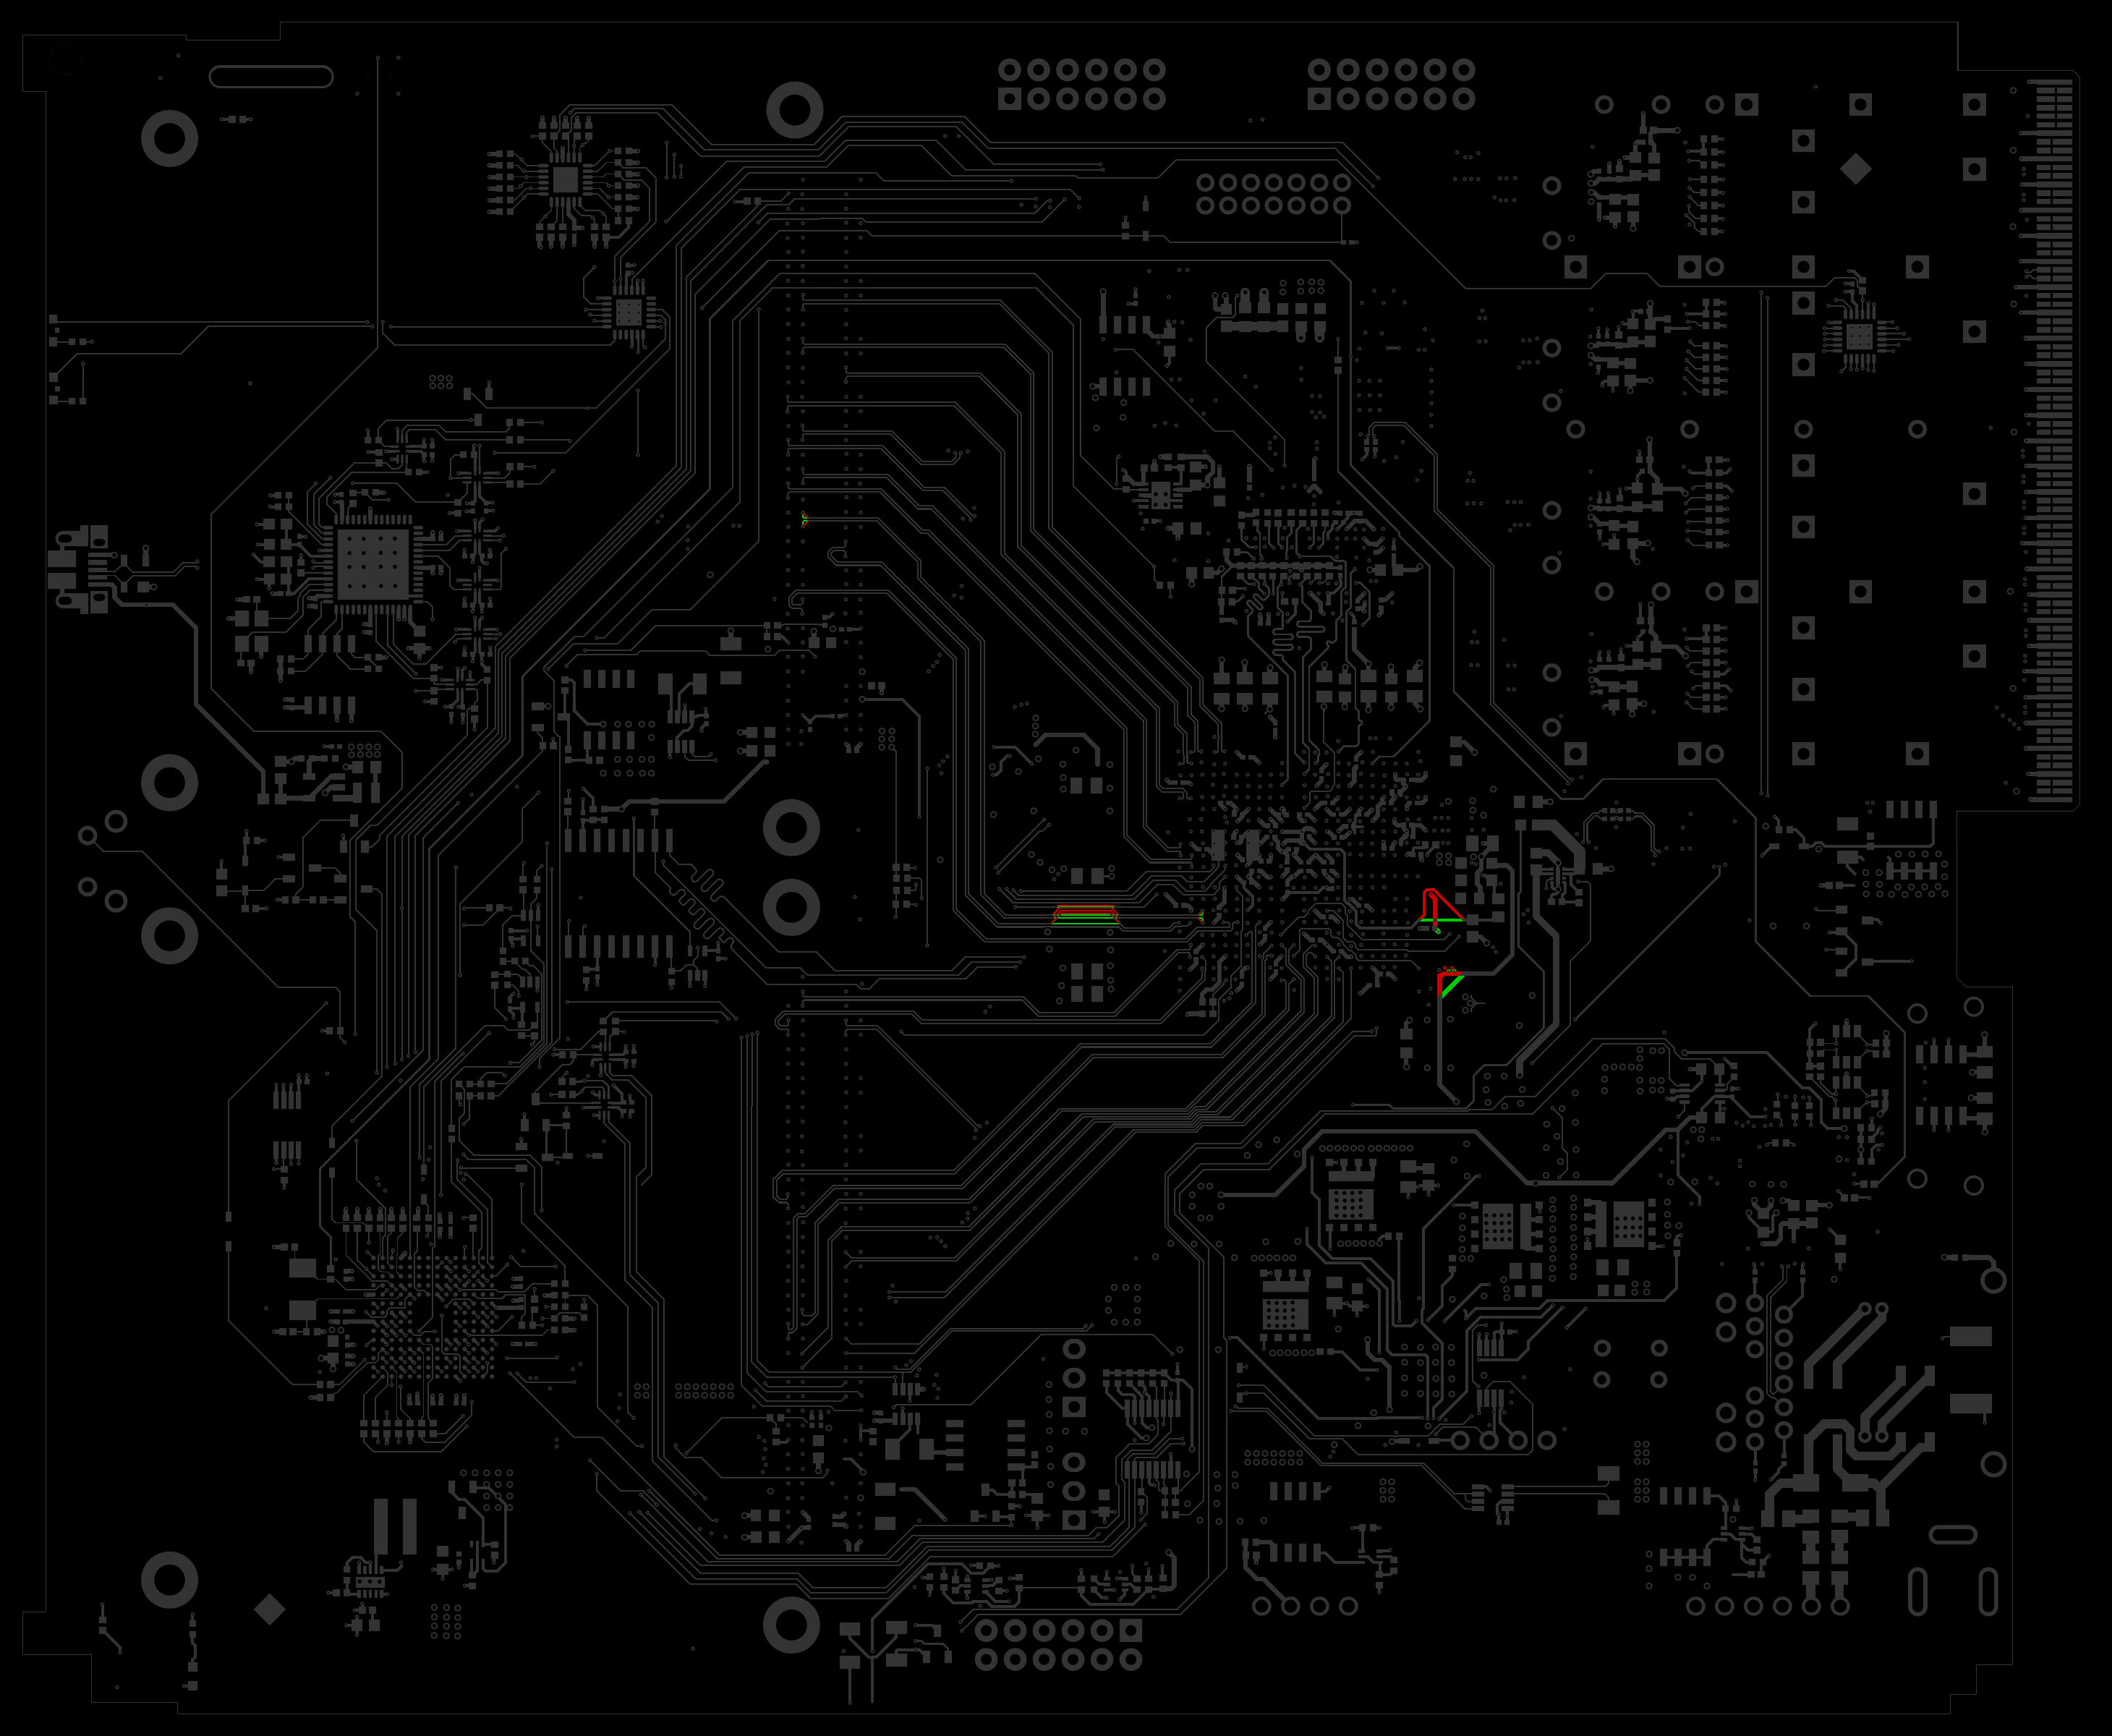

In [62]:
i_out = img_diff(i1, i2)
i_out.save('out.png')
i_out

In [2]:
import pcbnew

In [3]:
board = pcbnew.LoadBoard('../Marble/AMC_FMC_Carrier-PcbDoc.kicad_pcb')

In [4]:
boardbox = board.ComputeBoundingBox()
bounds = {
    'x': boardbox.GetX() / 1e6 / 25.4,
    'y': boardbox.GetY() / 1e6 / 25.4,
    'W': boardbox.GetWidth() / 1e6 / 25.4,
    'H': boardbox.GetHeight() / 1e6 / 25.4,
}
print(bounds) # [inch]

{'y': 2.4708417716535434, 'x': 4.592234251968504, 'W': 7.38702562992126, 'H': 6.334671535433071}


In [10]:
pctl = pcbnew.PLOT_CONTROLLER(board)
pctl.SetColorMode(True)

popt = pctl.GetPlotOptions()
popt.SetOutputDirectory('./diff_temp1')
popt.SetPlotFrameRef(False)
# popt.SetLineWidth(pcbnew.FromMM(0.15))
# popt.SetAutoScale(False)
popt.SetScale(1)
popt.SetMirror(False)
popt.SetUseGerberAttributes(True)
popt.SetExcludeEdgeLayer(False)
# popt.SetUseAuxOrigin(True)
popt.SetDrillMarksType(popt.FULL_DRILL_SHAPE)

In [7]:
pctl.SetLayer(board.GetLayerID('B.Cu'))

In [29]:
zf = pcbnew.ZONE_FILLER(board)

In [33]:
zf.Fill(board.Zones())

True

In [11]:
pctl.SetLayer(pcbnew.F_Cu)
pcbnew.Refresh()
pctl.OpenPlotfile('F_Cu', pcbnew.PLOT_FORMAT_PDF, 'Top layer')
pctl.PlotLayer()
pctl.ClosePlot()

# the sequence

In [53]:
f_name = 'AMC_FMC_Carrier-PcbDoc.kicad_pcb'
commit = 'HEAD~5'
layers = ['F.Cu', 'B.Cu', 'F.SilkS', 'B.SilkS']
layers += ['In{}.Cu'.format(i) for i in range(1, 7)]
print(layers)

['F.Cu', 'B.Cu', 'F.SilkS', 'B.SilkS', 'In1.Cu', 'In2.Cu', 'In3.Cu', 'In4.Cu', 'In5.Cu', 'In6.Cu']


In [54]:
dir1 = 'plot_' + desc()
print('Plot into ' + dir1)
bounds1 = plot_layers(f_name, dir1, layers)

os.system('git checkout {}'.format(commit))
dir2 = 'plot_' + desc()
print('Plot into ' + dir2)
bounds2 = plot_layers(f_name, dir2, layers)

os.system('git checkout -')

Plot into plot_v1.0rc2-75-gf1882e2
Plot into plot_v1.0rc2-69-g231be57


0

In [62]:
try:
    os.mkdir('diffs')
except OSError:
    pass

for l in layers:
    pdf_name = splitext(f_name)[0] + '-' + l.replace('.', '_') + '.pdf'  
    out_file = 'diffs/' + l + '.png'
    print(out_file)
    
    i1 = load_pdf(join(dir1, pdf_name), r=400, **bounds1)
    i2 = load_pdf(join(dir2, pdf_name), r=400, **bounds1)
    i_out = img_diff(i1, i2)
    i_out.save(out_file)
    
rmtree(dir1)
rmtree(dir2)

diffs/F.Cu.png
diffs/B.Cu.png
diffs/F.SilkS.png
diffs/B.SilkS.png
diffs/In1.Cu.png
diffs/In2.Cu.png
diffs/In3.Cu.png
diffs/In4.Cu.png
diffs/In5.Cu.png
diffs/In6.Cu.png
